In [41]:
import os
import cv2
import glob
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import itertools
from sklearn.metrics import confusion_matrix


In [42]:
# Ignore the warning
warnings.filterwarnings("ignore")
# Auto-reload extensions
%reload_ext autoreload
%autoreload 2
# Display Matplotlib plots inline
%matplotlib inline

In [ ]:
##### Load the data from zipfile locally#####

# import zipfile

# zip_file_path = os.path.join('..', 'raw_data', 'archive.zip')
# extract_dir = os.path.join('..', 'raw_data', 'cnn_data')

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# extracted_files = os.listdir(extract_dir)
# print("Extracted files:", extracted_files)

# Data Exploration
1. remove the Grayscale images
2. resize images
3. normalization
4. argumentation

## Remove Grayscale images

In [ ]:
styles = [
    'Achaemenid architecture',
    'American craftsman style',
    'American Foursquare architecture',
    'Ancient Egyptian architecture',
    'Art Deco architecture',
    'Art Nouveau architecture',
    'Baroque architecture',
    'Bauhaus architecture',
    'Beaux-Arts architecture',
    'Byzantine architecture',
    'Chicago school architecture',
    'Colonial architecture',
    'Deconstructivism',
    'Edwardian architecture',
    'Georgian architecture',
    'Gothic architecture',
    'Greek Revival architecture',
    'International style',
    'Novelty architecture',
    'Palladian architecture',
    'Postmodern architecture',
    'Queen Anne architecture',
    'Romanesque architecture',
    'Russian Revival architecture',
    'Tudor Revival architecture'
]

In [ ]:
from PIL import Image

base_folder_path = '../raw_data/cnn_data/architectural-styles-dataset'

def black_white(image_path):
    image = Image.open(image_path).convert('RGB')
    image_array = np.array(image)

    if np.all(image_array[:, :, 0] == image_array[:, :, 1]) and  np.all(image_array[:, :, 1]== image_array[:, :, 2]):
        return True
    else:
        return False


def process_images_in_style(style_name):
    folder_path = os.path.join(base_folder_path, style_name)
    deleted_count = 0
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return

    for file_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, file_name)
        if black_white(image_path):
            os.remove(image_path)
            deleted_count += 1
#             print(f"Grayscale image found: {file_name} in {style_name}")

    print(f"Deleted {deleted_count} files in the {style_name}")


In [ ]:
# Process images for each folder
for style in styles:
    print(f"Processing images for style: {style}")
    process_images_in_style(style)

## Split the dataset into Train/Val/Test

In [ ]:
import shutil
import random

# Define the base directory where the data is currently located
base_dir = '../raw_data/cnn_data/architectural-styles-dataset'
# Define the new base directory where the train/val/test folders will be created
new_base_dir = '../raw_data/cnn_data'

# Create directories for train, val, and test sets
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
test_dir = os.path.join(new_base_dir, 'test')

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


# Function to split and copy files
def split_and_copy_files(style_name):
    source_folder = os.path.join(base_dir, style_name)
    if not os.path.exists(source_folder):
        print(f"Folder not found: {source_folder}")
        return

    files = os.listdir(source_folder)
    random.shuffle(files)

    # Calculate split indices
    total_files = len(files)
    train_count = int(0.7 * total_files)
    val_count = int(0.15 * total_files)

    train_files = files[:train_count]
    val_files = files[train_count:train_count + val_count]
    test_files = files[train_count + val_count:]

    # Create style-specific directories in train, val, and test folders
    train_style_dir = os.path.join(train_dir, style_name)
    val_style_dir = os.path.join(val_dir, style_name)
    test_style_dir = os.path.join(test_dir, style_name)

    os.makedirs(train_style_dir, exist_ok=True)
    os.makedirs(val_style_dir, exist_ok=True)
    os.makedirs(test_style_dir, exist_ok=True)

    # Copy files to respective directories
    for file_name in train_files:
        shutil.copy(os.path.join(source_folder, file_name), os.path.join(train_style_dir, file_name))

    for file_name in val_files:
        shutil.copy(os.path.join(source_folder, file_name), os.path.join(val_style_dir, file_name))

    for file_name in test_files:
        shutil.copy(os.path.join(source_folder, file_name), os.path.join(test_style_dir, file_name))

    print(f"Processed {style_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")


# Split and copy files for each style
for style in styles:
    split_and_copy_files(style)

In [43]:
import shutil
import random

# Define the base directory where the data is currently located
base_dir = '../raw_data/cnn_data/architectural-styles-dataset'
# Define the new base directory where the train/val/test folders will be created
new_base_dir = '../raw_data/cnn_data'

# Create directories for train, val, and test sets
train_dir = os.path.join(new_base_dir, 'train')
val_dir = os.path.join(new_base_dir, 'val')
test_dir = os.path.join(new_base_dir, 'test')

## Resize the Images

In [44]:
from tensorflow.keras.utils import image_dataset_from_directory

# Define the batch size
batch_size = 32

train_ds = image_dataset_from_directory(
  train_dir,
  labels = "inferred",
  label_mode = "int",
  seed=123,
  image_size=(150, 150),
  batch_size=batch_size)

# We define a second one for the test data
val_ds = image_dataset_from_directory(
  val_dir,
  labels = "inferred",
  label_mode = "int",
  seed=123,
  image_size=(150, 150),
  batch_size=batch_size)

test_ds = image_dataset_from_directory(
  test_dir,
  labels = "inferred",
  label_mode = "int",
  seed=123,
  image_size=(150, 150),
  batch_size=batch_size)

Found 6918 files belonging to 25 classes.
Found 1472 files belonging to 25 classes.
Found 1511 files belonging to 25 classes.


In [45]:
class_names = train_ds.class_names
print(class_names)

['Achaemenid architecture', 'American Foursquare architecture', 'American craftsman style', 'Ancient Egyptian architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Bauhaus architecture', 'Beaux-Arts architecture', 'Byzantine architecture', 'Chicago school architecture', 'Colonial architecture', 'Deconstructivism', 'Edwardian architecture', 'Georgian architecture', 'Gothic architecture', 'Greek Revival architecture', 'International style', 'Novelty architecture', 'Palladian architecture', 'Postmodern architecture', 'Queen Anne architecture', 'Romanesque architecture', 'Russian Revival architecture', 'Tudor Revival architecture']


In [46]:
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Data Normalize and Augmentation

In [47]:
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.data import AUTOTUNE

# Define data augmentation layers
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomTranslation(0.2, 0.2)
])

In [48]:
# Normalize the data
normalization_layer = Rescaling(1./255)

# Apply the normalization layer to the datasets
train_ds = train_ds.map(lambda x, y: (data_augmentation(normalization_layer(x)), y), num_parallel_calls=tf.data.AUTOTUNE)

val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

# Prefetch the datasets for better performance
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds

# Build and Train Model

In [49]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img



def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [50]:
def plot_compare_history(history, name_history, history_1, name_history_1):

    fig, ax = plt.subplots(1, 2, figsize=(15,5))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss " + name_history)
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss " + name_history)

    ax[0].plot(history_1.epoch, history_1.history["loss"], label="Train loss " + name_history_1)
    ax[0].plot(history_1.epoch, history_1.history["val_loss"], label="Validation loss " + name_history_1)

    ax[1].set_title('Accuracy')

    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy " + name_history)
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy " + name_history)

    ax[1].plot(history_1.epoch, history_1.history["accuracy"], label="Train Accuracy " + name_history_1)
    ax[1].plot(history_1.epoch, history_1.history["val_accuracy"], label="Validation Accuracy " + name_history_1)

    ax[0].legend()
    ax[1].legend()

## 1. VGG16 Model

In [74]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (150, 150, 3))

In [75]:
inputs = layers.Input(shape = (150, 150, 3))

# x = data_augmentation(inputs)
# x = layers.Rescaling(1./255)(x)
x = preprocess_input(inputs) # Then a preprocessing layer specifically designed for the VGG16
x = base_model(x) # Then our transfer learning model

x = layers.Flatten()(x) # Followed by our custom dense layers, tailored to our binary task

x = layers.Dense(64, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
pred = layers.Dense(25, activation = "softmax")(x)

# We use the keras Functional API to create our keras model

model_vgg = Model(inputs = inputs , outputs = pred)

# And we freeze the VGG16 model
base_model.trainable = False

In [76]:
model_vgg.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 tf.__operators__.getitem_5   (None, 150, 150, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 8192)              0         
                                                                 
 dense_17 (Dense)            (None, 64)                5243

In [77]:
adam = optimizers.Adam(learning_rate = 0.001)
model_vgg.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [78]:
MODEL = "model_vgg"

modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

In [79]:
%%time
history_vgg = model_vgg.fit(
        train_ds,
        epochs=10,
        validation_data=val_ds,
        callbacks = [modelCheckpoint, LRreducer, EarlyStopper])

Epoch 1/10
217/217 [==============================] - 751s 3s/step - loss: 3.2389 - accuracy: 0.0635 - val_loss: 3.2071 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 2/10
217/217 [==============================] - 670s 3s/step - loss: 3.2034 - accuracy: 0.0718 - val_loss: 3.1990 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 3/10
217/217 [==============================] - 1322s 6s/step - loss: 3.1969 - accuracy: 0.0718 - val_loss: 3.1937 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 4/10
217/217 [==============================] - 10963s 51s/step - loss: 3.1927 - accuracy: 0.0718 - val_loss: 3.1904 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 5/10
217/217 [==============================] - 513s 2s/step - loss: 3.1901 - accuracy: 0.0718 - val_loss: 3.1883 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 6/10
217/217 [==============================] - 517s 2s/step - loss: 3.1885 - accuracy: 0.0718 - val_loss: 3.1870 - val_accuracy: 0.0720 - lr: 0.0010
Epoch 7/10
217/217 [==============================] - 524s 2

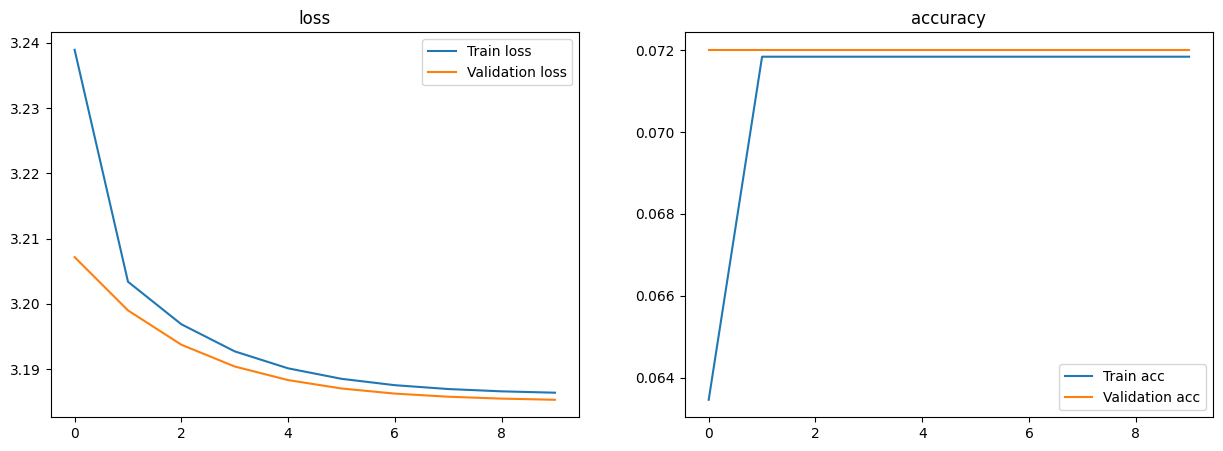

In [80]:
plot_history(history_vgg)

## 2. CS231N Model

In [81]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

def create_cs231n_model(input_shape=(150, 150, 3), num_classes=25):
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model

In [82]:
# Define input shape and number of classes
input_shape = (150, 150, 3)
num_classes = 25

model_cs231n  = create_cs231n_model(input_shape , num_classes)

In [83]:
model_cs231n.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)     

In [84]:
adam = optimizers.Adam(learning_rate = 0.001)
model_cs231n.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [85]:
modelCheckpoint = callbacks.ModelCheckpoint("model_cs231n.h5", monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

In [86]:
history_cs231n = model_cs231n.fit(
        train_ds,
        epochs=20,
        validation_data=val_ds,
        callbacks=[modelCheckpoint, LRreducer, EarlyStopper]
)

Epoch 1/20
217/217 [==============================] - 97s 429ms/step - loss: 3.1946 - accuracy: 0.0588 - val_loss: 3.1084 - val_accuracy: 0.0910 - lr: 0.0010
Epoch 2/20
217/217 [==============================] - 71s 325ms/step - loss: 3.0142 - accuracy: 0.1182 - val_loss: 2.7922 - val_accuracy: 0.1522 - lr: 0.0010
Epoch 3/20
217/217 [==============================] - 67s 308ms/step - loss: 2.7995 - accuracy: 0.1619 - val_loss: 2.6099 - val_accuracy: 0.2188 - lr: 0.0010
Epoch 4/20
217/217 [==============================] - 65s 299ms/step - loss: 2.6234 - accuracy: 0.2069 - val_loss: 2.4908 - val_accuracy: 0.2317 - lr: 0.0010
Epoch 5/20
217/217 [==============================] - 64s 294ms/step - loss: 2.4354 - accuracy: 0.2512 - val_loss: 2.3682 - val_accuracy: 0.2812 - lr: 0.0010
Epoch 6/20
217/217 [==============================] - 64s 296ms/step - loss: 2.2583 - accuracy: 0.2981 - val_loss: 2.3606 - val_accuracy: 0.2819 - lr: 0.0010
Epoch 7/20
217/217 [==============================] 

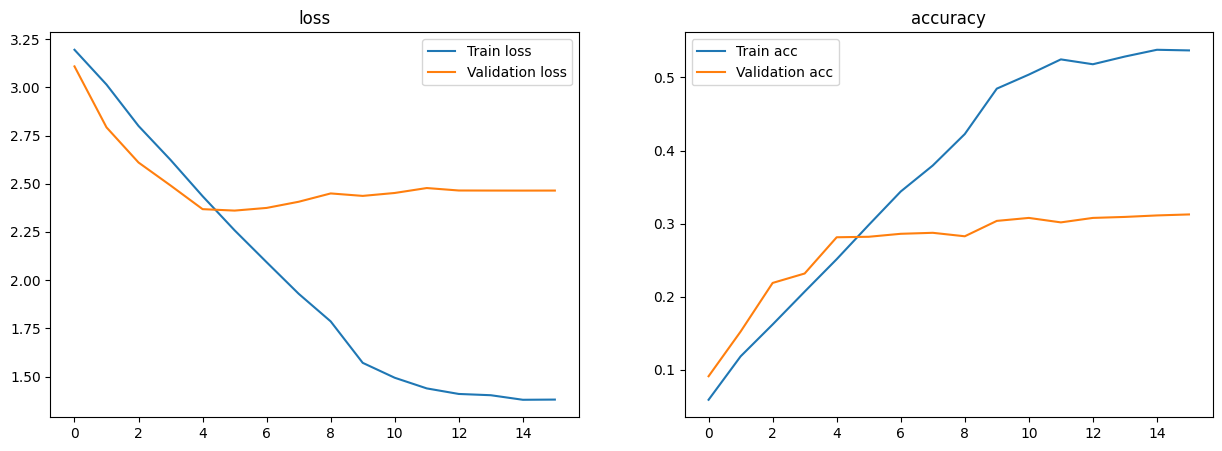

In [87]:
plot_history(history_cs231n)